In [1]:
!pip install -q git+https://github.com/phatvucoder/pdatakit.git
!pip -q install gdown
!sudo apt-get update & sudo apt-get install unzip

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1172 kB]
Get:4 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]   
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:6 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]       
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Hit:8 https://packages.cloud.google.com/apt google-fast-socket InRelease
Get:9 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [28.6 kB]
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1582 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3323 kB]
Get:12 https://packages.cloud.google.com/apt cloud-sdk/main am

In [2]:
!gdown 1D1YYc2nxpifm9tLqH8v9jxMvZtjtwFuZ
!unzip -q obj_bkgr -d dataset
!rm -rf ./dataset/__MACOSX

Downloading...
From (original): https://drive.google.com/uc?id=1D1YYc2nxpifm9tLqH8v9jxMvZtjtwFuZ
From (redirected): https://drive.google.com/uc?id=1D1YYc2nxpifm9tLqH8v9jxMvZtjtwFuZ&confirm=t&uuid=f691bd5a-f374-48e2-b3db-2f2d5345ea1b
To: /kaggle/working/obj_bkgr.zip
100%|██████████████████████████████████████| 1.54G/1.54G [00:23<00:00, 64.4MB/s]


In [3]:
from pdatakit.pod.data_processor import DataProcessor
from pdatakit.pod.data_formatter import FormatType
import shutil

In [4]:
# shutil.copytree('/kaggle/input/bkai2024', '/kaggle/working/bkai2024')

In [5]:
processor = DataProcessor(
    data_root='./dataset/nighttime',
    image_extension='jpg',
    label_extension='txt',
    train_size=0.7,
    val_size=0.2,
    test_size=0.1,
    random_state=42
)

In [6]:
for i in range(4, 8):
    processor.process_labels(i, i-4)

Replacing '4' with '0' in label files...
Label replacement completed. Processed 4629 files, modified 3867 files.
Replacing '5' with '1' in label files...
Label replacement completed. Processed 4629 files, modified 2683 files.
Replacing '6' with '2' in label files...
Label replacement completed. Processed 4629 files, modified 1617 files.
Replacing '7' with '3' in label files...
Label replacement completed. Processed 4629 files, modified 1849 files.


In [7]:
processor.split_data()

Data splitting completed.
Training samples: 3232
Validation samples: 923
Testing samples: 474


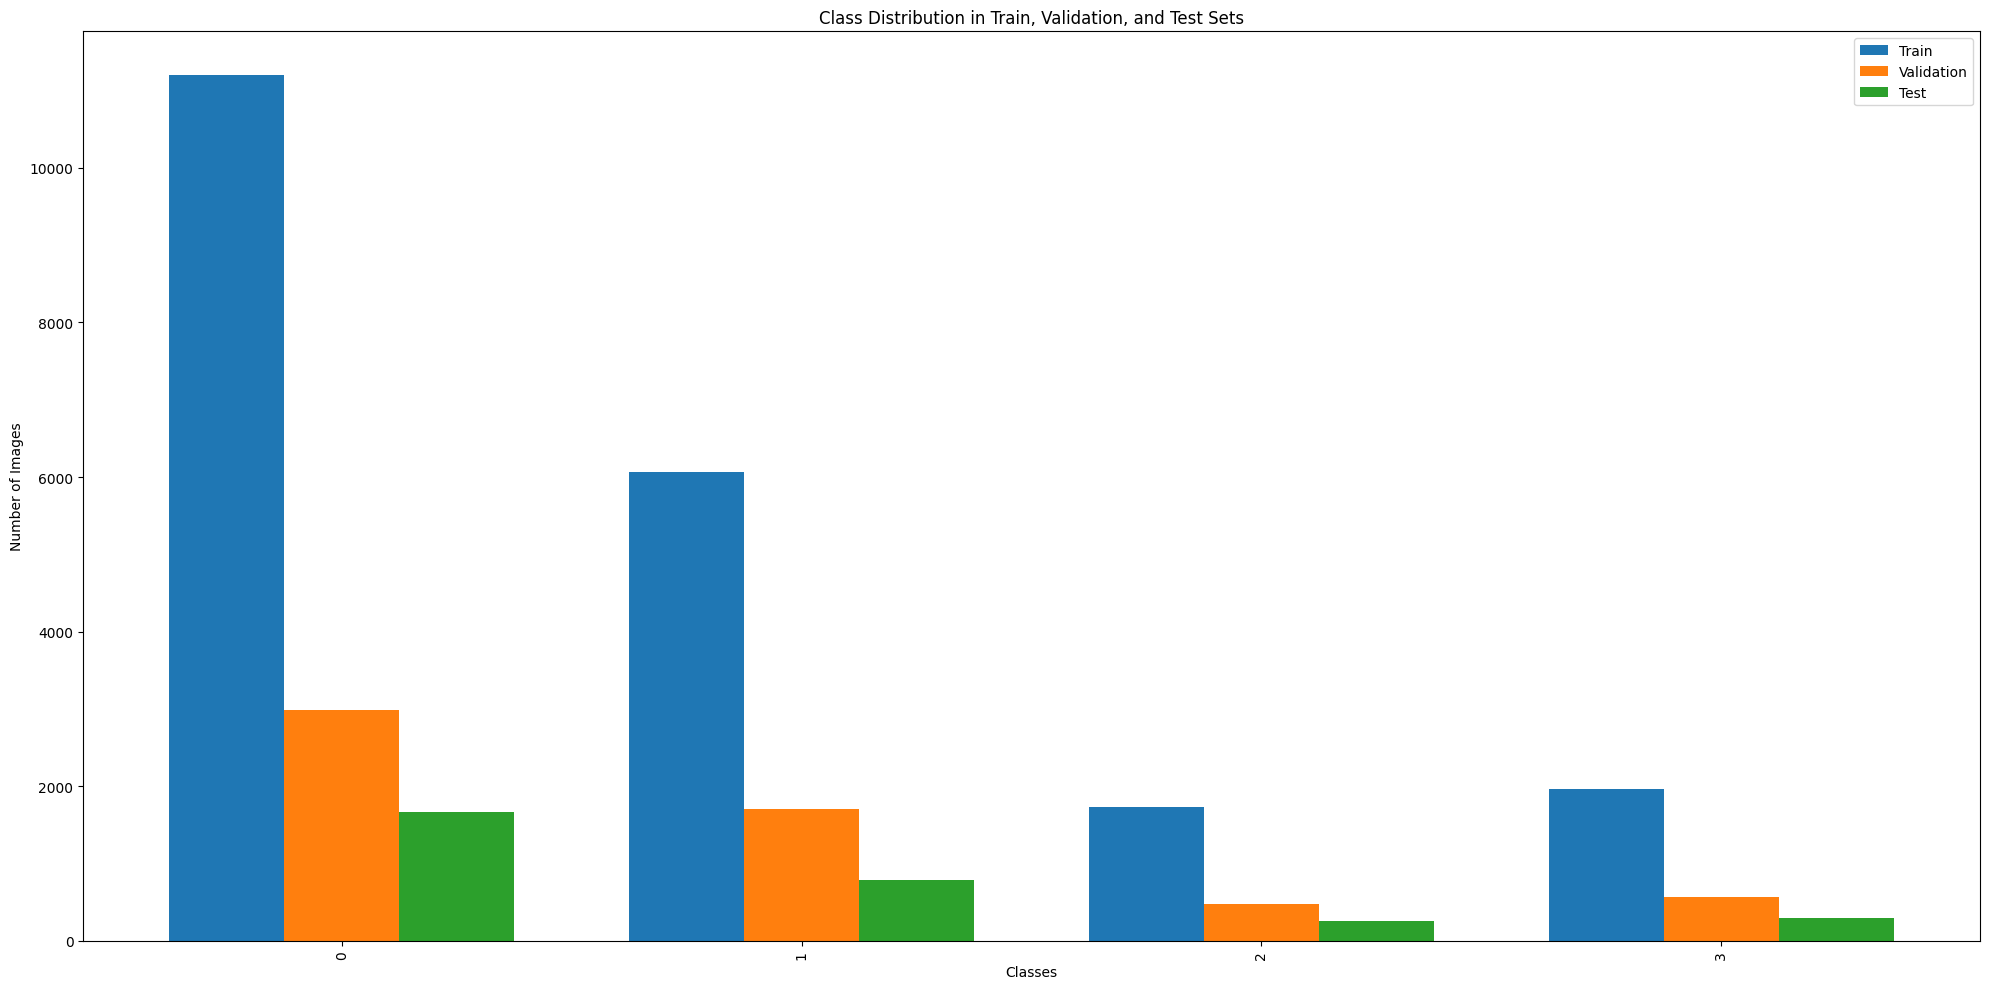

In [8]:
processor.visualize_distributions()

In [9]:
class_mapping = {
    0: 'motorbike',
    1: 'car',
    2: 'bus',
    3: 'truck'
}

# Format the data into YOLO New format and save to 'formatted_data' directory
processor.format_data(
    output_dir='./yolo_data',
    format_type=FormatType.YOLO_NEW,
    class_mapping=class_mapping
)

Creating YOLO New format...
Created data.yaml at yolo_data/data.yaml
YOLO New format created successfully.
Data formatted into yolo_new format and saved to ./yolo_data.


In [10]:
processor.summary()

===== Data Manager Summary =====
Data Root: ./dataset/nighttime
Image Extension: jpg
Label Extension: txt
Total Images: 4629
Total Labels: 4629
Training Samples: 3232
Validation Samples: 923
Testing Samples: 474
Class Distribution in Training Set:
  0: 11206
  1: 6061
  2: 1732
  3: 1962
Class Distribution in Validation Set:
  0: 2987
  1: 1703
  2: 472
  3: 567
Class Distribution in Testing Set:
  0: 1664
  1: 790
  2: 258
  3: 294


In [11]:
import numpy as np

class_distribution = processor.splitter.get_class_distribution()
total_samples_per_class = np.sum(class_distribution, axis=0)
total_samples = np.sum(total_samples_per_class)
class_weights = total_samples / total_samples_per_class
class_weights

array([ 1.87273759,  3.47159224, 12.06173842, 10.5193057 ])

In [12]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5933.9/8062.4 GB disk)


In [13]:
!yolo train data=/kaggle/working/yolo_data/data.yaml model=yolo11m.pt lr0=0.0001 epochs=100 batch=32 device=0,1 cache=ram

100%|███████████████████████████████████████| 38.8M/38.8M [00:00<00:00, 209MB/s]
Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/kaggle/working/yolo_data/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=ram, device=(0, 1), workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=N

In [14]:
import shutil
shutil.copy('/kaggle/working/runs/detect/train/weights/best.pt', '/kaggle/working/night_m.pt')

from IPython.display import FileLink
FileLink(r'night_m.pt')

/kaggle/working/night_m.pt